In [1]:
import pandas as pd
import numpy as np
import json
import matplotlib.pylab as plt
try:
    import seaborn as sns
except ImportError:
    print('Seaborn not found')
%matplotlib inline
from IPython.display import display

from tyssue import config
from tyssue import Sheet, SheetGeometry as geom
from tyssue.dynamics import SheetModel as model

from tyssue.solvers.sheet_vertex_solver import Solver as solver
from tyssue.dynamics.sheet_isotropic_model import isotropic_relax

from tyssue.draw.plt_draw import quick_edge_draw, plot_forces
from tyssue.draw.threejs_draw import view_3js

from tyssue.io import hdf5

from tyssue.core.objects import get_opposite
from tyssue.core.generation import create_anchors

from tyssue.topology.sheet_topology import cell_division

In [2]:
h5store = '../data/hf5/small_hexagonal.hf5'

datasets = hdf5.load_datasets(h5store,
                              data_names=['face',
                                          'vert',
                                          'edge'])

specs = config.geometry.cylindrical_sheet()
sheet = Sheet('emin', datasets, specs)
geom.update_all(sheet)

# ## Boundary conditions
sheet.vert_df.is_active = 1

sheet.edge_df['opposite'] = get_opposite(sheet.edge_df)
create_anchors(sheet)
anchor_tension = 0.6

nondim_specs = config.dynamics.quasistatic_sheet_spec_anchors()
nondim_specs['edge']['anchor_tension'] = anchor_tension
dim_model_specs = model.dimentionalize(nondim_specs)
sheet.update_specs(dim_model_specs, reset=True)

geom.update_all(sheet)

In [3]:
sheet.Nf, sheet.Ne, sheet.Nv

(56, 272, 96)

In [4]:
res = solver.find_energy_min(sheet, geom, model)


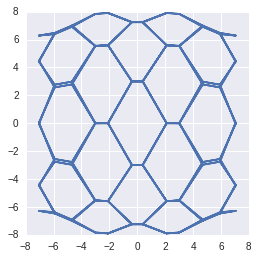

In [5]:
fig, ax = quick_edge_draw(sheet, ['z', 'x'])

False


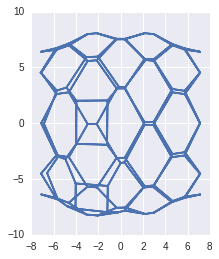

In [7]:
cell_division(sheet, 16, geom, angle=0)

res = solver.find_energy_min(sheet, geom, model)
print(res['success'])

fig, ax = quick_edge_draw(sheet, ['z', 'x'])

In [8]:
renderer, line = view_3js(sheet)
display(renderer)

In [9]:
ngen = 3
anchors = sheet.edge_df[sheet.edge_df.is_anchor == 1].index

a_srce = sheet.edge_df.loc[anchors, 'srce'].astype(np.int)
a_trgt = sheet.edge_df.loc[anchors, 'trgt'].astype(np.int)

for n in range(ngen):
    live_cells = np.array(sheet.face_df[sheet.face_df.is_alive==1].index)
    np.random.shuffle(live_cells)
    print('Generation {}: {} cells to devide'
         .format(n, len(live_cells)))
    for cell in live_cells:
        V0 = sheet.face_df.loc[cell, 'prefered_vol']
        sheet.face_df.loc[cell, 'prefered_vol'] = 1.5*V0
        daughter = cell_division(sheet, cell, geom, angle=None)
        if daughter is None:
            continue
        sheet.face_df.loc[[cell, daughter],'prefered_vol'] = V0
        res = solver.find_energy_min(sheet, geom, model)
        #isotropic_relax(sheet, nondim_specs)
        sheet.vert_df.loc[a_trgt, sheet.coords] = sheet.vert_df.loc[a_srce, sheet.coords]
        sheet.vert_df.loc[a_trgt, 'z'] += 1e-3
        
draw_specs = config.draw.sheet_spec()
draw_specs['vert']['visible'] = False



Generation 0: 42 cells to devide
Generation 1: 84 cells to devide
Generation 2: 168 cells to devide


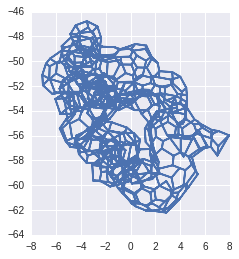

In [10]:
fig, ax = quick_edge_draw(sheet, ['z', 'x'])

In [11]:
renderer, line = view_3js(sheet)
display(renderer)

In [12]:
sheet.Nf, sheet.Ne, sheet.Nv

(336, 1952, 656)